## Customer Churn Prediciton 

In [3]:
import pandas as pd 

df = pd.read_csv('dataset.csv')
df

### Section 1: Data Pre-Processing, EDA, and Multicollinearity

#### 0. Fixing Data Types

1. TotalCharges has to be float

In [7]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

#### 1. Dataset Summary

In [8]:
from summarytools import dfSummary
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,customerID[object],1. 7590-VHVEG2. 3791-LGQCY3. 6008-NAIXK4. 5956-YHHRX5. 5365-LLFYV6. 5855-EIBDE7. 8166-ZZTFS8. 0129-KPTWJ9. 9128-CPXKI10. 9509-MPYOD11. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)7,033 (99.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,gender[object],1. Male2. Female,"3,555 (50.5%)3,488 (49.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABN0lEQVR4nO3bwYnDMBRF0a8gwmQjYQwuxkVMsSlC3RhjLZKQjWYxDcR/8YTIPRV8zMWQ4BdaawYoBDO7mdm19yEDerfWnr2PGEmc5/k3pTT1PmQ0tdY9hHAnuM/FlNK0rusz5/zqfcwojuP4KaVM27ZdzYzYPhTNzHLOr2VZHr2PGcyt9wGjufQ+AN+D2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGmWj2/zFg70NGwvPyibXWvZQyGR8DnlJr3c3s3fuOkTB48WPwclJgygcV3mw+vNUcmPI5MOPzYcp3EjM+P6Z8Pvxyd+BPXcgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggw5TvJJ6VH1M+B2Z8PgxefBi8OPwBCltq31np+ZoAAAAASUVORK5CYII="">",0(0.0%)
3,SeniorCitizen[int64],1. 02. 1,"5,901 (83.8%)1,142 (16.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABMUlEQVR4nO3bQWrDMBRF0adiQjORMAYvxovoYrsI7cYYa9CETNRByRL+swr3bOAHchNI8Eu9dwEOSdJd0u3qF4LLvXrvj8gD07IsXznnOfIIxtdaO1JK35HBTTnnedu2RynlGXUEYzvP87PWOu/7fpMUF5sklVKe67r+RB3Bv3CPPvARfQB4IzbYEBtsiA02xAYbYoMNscGG2GBDbLAhNtgQG2yIDTbEBhtigw2xwWaS/h6eu/qF4Dqu939qrR211lmGh+cwrtbaIekVeYPBC97CBy+JKR9cXN9s4Z8ajM8y5XPMxDC+8CmfayaG8bmmfPzSBX/qwofYYENssCE22BAbbIgNNsQGG2KDDbHBhthgQ2ywITbYEBtsiA02xAab8CkfM0G8WaZ8jpkYxsfgBTa/Cltq33c4jS0AAAAASUVORK5CYII="">",0(0.0%)
4,Partner[object],1. No2. Yes,"3,641 (51.7%)3,402 (48.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABOUlEQVR4nO3bwYnDMBRF0a9BhMlGwhhcjIuYYqcIdWOMtUhCNspiCog1gidE7qngYy6GBD9XSjFAwZnZ1cwuvQ8Z2LOUcu99xAj8PM8/IYSp9yGjyjnvzrlfgnvPhxCmdV3vMcZH72NGcxzHd0pp2rbtYmbE9oY3M4sxPpZlufU+ZlDX3geM4qv3AfgcxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yHizv48Aex8yIp5bHZ9z3lNKk/ER4L/knHcze/a+YwQMXtoxeDnJMeWDCm+2OrzFGjDlq8Bsrw1TvpOY7bVjyleHX+wN+FMXMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgw5TuJZ9SOKV8FZnttGLzUYfDS4AUKW2rfd+DJGgAAAABJRU5ErkJggg=="">",0(0.0%)
5,Dependents[object],1. No2. Yes,"4,933 (70.0%)2,110 (30.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIH

#### 2. Analyzing Missing Values

The Dataset seems to be missing a few values in the 'Total Charges' column due to coercing any error in dtype transformation 

<Axes: >

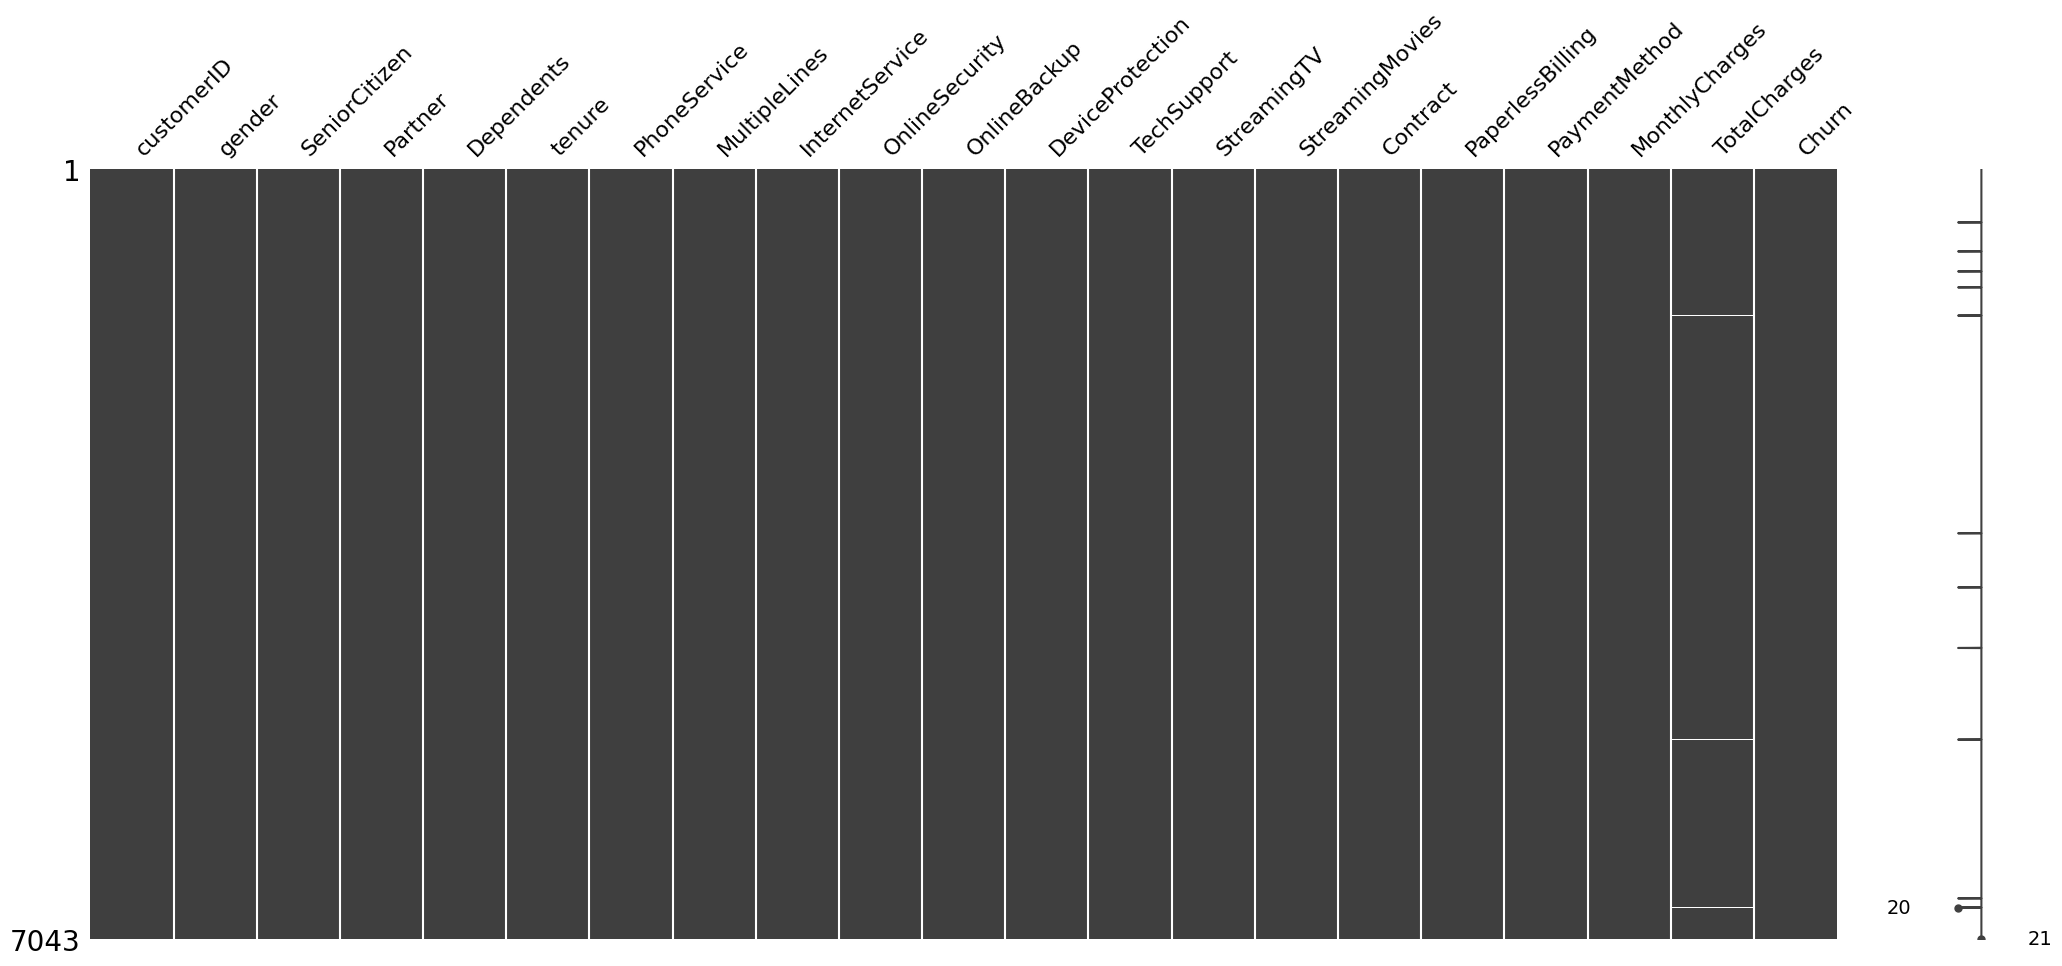

In [9]:
import missingno as msno
%matplotlib inline
msno.matrix(df)

#### 3. Correlation Analysis

From the correlation analysis, we observe that some variables are highly correlated with each other. This can pose issues to any machine learning algorithm due to multicollinearity.

Multicollinearity can invalidate the coefficients or interpretation of the variables. This necessitates addressing multicollinearity to ensure the robustness and accuracy of machine learning models.

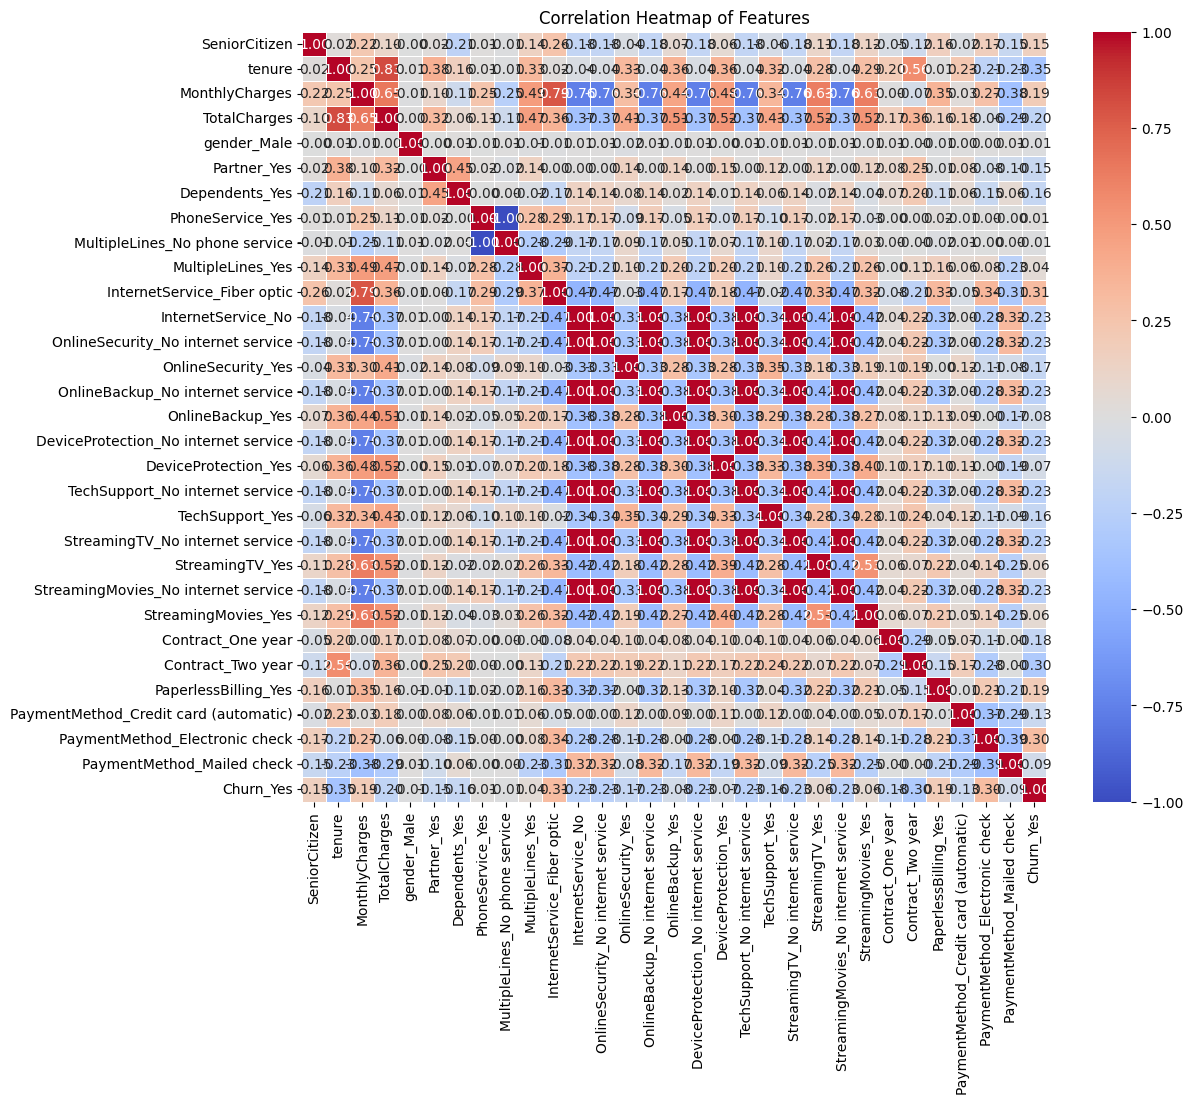

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

data_encoded = pd.get_dummies(df.drop('customerID', axis=1), drop_first=True)
correlation_matrix = data_encoded.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set the title and show the plot
plt.title('Correlation Heatmap of Features')
plt.show()

Now we're going to identify highly pearson correlated variables

In [30]:
# Threshold for correlation
threshold = 0.8

# Find pairs with correlation above the threshold
high_corr_pairs = [(i, j) for i in correlation_matrix.columns for j in correlation_matrix.columns if i != j and abs(correlation_matrix.loc[i, j]) > threshold]

#### Variance Inflation Factor (VIF)

We will now remove any column that have a VIF higher than 10 

In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

data_encoded_no_na = data_encoded.dropna()
data_encoded_no_na[data_encoded_no_na.select_dtypes(include=['bool']).columns] = data_encoded_no_na.select_dtypes(include=['bool']).astype(int)

X = sm.add_constant(data_encoded_no_na)

# List of variables to drop (already did VIF, this is hindsight)
columns_remove = ['OnlineSecurity_No internet service', 'DeviceProtection_No internet service', 'StreamingMovies_No internet service', 'OnlineBackup_No internet service',
                  'StreamingTV_No internet service', 'MultipleLines_No phone service', 'TechSupport_No internet service', 'MonthlyCharges', 'TotalCharges']

X = X.drop(columns_remove, axis=1)
# Calculating VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Printing VIF
vif_data.sort_values(by='VIF', ascending=False)


/var/folders/m9/zynt9hv96wl_5ndfq_x2mvp00000gn/T/ipykernel_61007/3299426551.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_encoded_no_na[data_encoded_no_na.select_dtypes(include=['bool']).columns] = data_encoded_no_na.select_dtypes(include=['bool']).astype(int)


,feature,VIF
0,const,24.119169
2,tenure,2.921471
9,InternetService_No,2.712771
17,Contract_Two year,2.637893
8,InternetService_Fiber optic,2.038994
20,PaymentMethod_Electronic check,1.981586
21,PaymentMethod_Mailed check,1.838243
16,Contract_One year,1.638606
15,StreamingMovies_Yes,1.636522
14,StreamingTV_Yes,1.627580


Using y-Data Overview for full overview of the data

In [ ]:
from ydata_profiling import ProfileReport

patient_report=ProfileReport(df.drop('customerID', axis=1))
patient_report

### Section 2: Machine Learning

0. Creating the Dataset - This also involves train and test split to see the accuracy of the model

In [53]:
from sklearn.model_selection import train_test_split

y = X.Churn_Yes
X = X.drop('Churn_Yes', axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

1. Logistic Regression

    The logistic regression was able to achieve an accuracy of 80% in predicting churn 
    
    Due to the fact that the dataset has very low number of Actual Churns, the model has less information

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Fit the logistic regression model using statsmodels
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Get the summary of the model
print(result.summary())

# Predict on the test set
y_pred_prob = result.predict(X_test)
y_pred = [1 if x > 0.5 else 0 for x in y_pred_prob]

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
print("\nAccuracy Score:")
print(accuracy)

Optimization terminated successfully.
         Current function value: 0.412464
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              Churn_Yes   No. Observations:                 4922
Model:                          Logit   Df Residuals:                     4900
Method:                           MLE   Df Model:                           21
Date:                Thu, 08 Aug 2024   Pseudo R-squ.:                  0.2876
Time:                        14:34:45   Log-Likelihood:                -2030.1
converged:                       True   LL-Null:                       -2849.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.1593      

2. Decsion Trees - More for data split vizualisation 

In [79]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import graphviz

# Create a decision tree classifier
dt_model = DecisionTreeClassifier(random_state=42, max_depth=3)

# Fit the model to the training data
dt_model.fit(X, y)

# Visualize the decision tree
dot_data = tree.export_graphviz(dt_model, out_file=None, 
                                feature_names=X.columns,  
                                class_names=['No', 'Yes'],  
                                filled=True, rounded=True,  
                                special_characters=True, )  
graph = graphviz.Source(dot_data)  
graph.render("decision_tree")  # Save the decision tree visualization to a file
graph.view()  # Display the decision tree visualization

'decision_tree.pdf'

3. Random Forest - More complex predictions from logistic

In [86]:
from sklearn.ensemble import RandomForestClassifier

rfm = RandomForestClassifier(n_estimators=350, bootstrap=True, 
                                 max_depth=20, min_samples_split=20)
rfm.fit(X_train, y_train)
    
# Make predictions
rf_pred = rfm.predict(X_test)

# Evaluate the model
print(accuracy_score(y_test, rf_pred))
print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

0.7938388625592417
[[1415  134]
 [ 301  260]]
              precision    recall  f1-score   support

           0       0.82      0.91      0.87      1549
           1       0.66      0.46      0.54       561

    accuracy                           0.79      2110
   macro avg       0.74      0.69      0.71      2110
weighted avg       0.78      0.79      0.78      2110



In [89]:
import shap
explainer_rf = shap.Explainer(rfm.predict, X_test)
shap_values = explainer_rf(X_test)

PermutationExplainer explainer: 2111it [21:03,  1.66it/s]                          
